# Generating Faces using a Convolutional VAE

## Creating A Convolutional VAE

### Import Necessary Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Conv2DTranspose, Dense
from tensorflow.keras.layers import Dropout, Flatten, Input, LeakyReLU, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Define Parameters And A Sampling Layer

In [2]:
input_dim = (128, 128, 3)

encoder_conv_filters       = [32, 64, 64, 64]
encoder_conv_kernel_size   = [3, 3, 3, 3]
encoder_conv_strides       = [2, 2, 2, 2]

decoder_conv_t_filters     = [64, 32, 32, 3]
decoder_conv_t_kernel_size = [3, 3, 3, 3]
decoder_conv_t_strides     = [2, 2, 2, 2]

z_dim = 200

class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, gamma = inputs
        return K.random_normal(tf.shape(gamma)) * K.exp(gamma / 2) + mean

### Define Encoder Model

In [3]:
encoder_input = Input(shape = input_dim, name = 'encoder_input')

x = encoder_input
for i in range(4):
    encoder_params = {
        'filters': encoder_conv_filters[i],
        'kernel_size': encoder_conv_kernel_size[i],
        'strides': encoder_conv_strides[i],
        'padding': 'same',
        'name': 'encoder_conv_' + str(i)
    }
    conv_layer = Conv2D(**encoder_params)
    x = conv_layer(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dropout(rate = 0.25)(x)
    
shape_before_flattening = K.int_shape(x)[1:]
x = Flatten()(x)

mean  = Dense(z_dim, name = 'mean')(x)
gamma = Dense(z_dim, name = 'gamma')(x)
encoder_output = Sampling()([mean, gamma])

encoder = Model(encoder_input, encoder_output, name = 'encoder')    

### Define Decoder Model

In [4]:
decoder_input = Input(shape = (z_dim, ), name = 'decoder_input')
x = Dense(np.prod(shape_before_flattening))(decoder_input)
x = Reshape(shape_before_flattening)(x)

for i in range(4):
    decoder_params = {
        'filters': decoder_conv_t_filters[i],
        'kernel_size': decoder_conv_t_kernel_size[i],
        'strides': decoder_conv_t_strides[i],
        'padding': 'same',
        'name': 'decoder_conv_' + str(i)
    }
    conv_t_layer = Conv2DTranspose(**decoder_params)
    x = conv_t_layer(x)
    if i < 3: 
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        x = Dropout(rate = 0.25)(x)
    else: 
        x = Activation('sigmoid')(x)
    
decoder_output = x
decoder = Model(decoder_input, decoder_output, name = 'decoder')


### Define Convolutional VAE

In [5]:
model_input  = encoder(encoder_input)
model_output = decoder(model_input)
model        = Model(encoder_input, model_output)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 128, 128, 3)]     0         
_________________________________________________________________
encoder (Model)              (None, 200)               1732944   
_________________________________________________________________
decoder (Model)              (None, 128, 128, 3)       889315    
Total params: 2,622,259
Trainable params: 2,621,555
Non-trainable params: 704
_________________________________________________________________


### Define Loss Function, And Compile The Model With An Adam Optimizer

In [6]:
latent_loss = -0.0005 * K.sum(1 + gamma - K.exp(gamma) - K.square(mean), axis = -1)
model.add_loss(latent_loss)

optimizer = Adam(learning_rate = 0.001)
model.compile(optimizer = optimizer, loss = 'mse')

## Faces dataset

### Data Preperation

In [10]:
generator = ImageDataGenerator(rescale = 1. / 255)

params = {
    'batch_size': 2, 
    'directory': './images/', #images folder has a sub folder that contains actual images
    'shuffle': True, 
    'target_size': (128, 128),
    'class_mode': 'input'
}

image_data_generator = generator.flow_from_directory(**params)

Found 5186 images belonging to 1 classes.


### Display Images

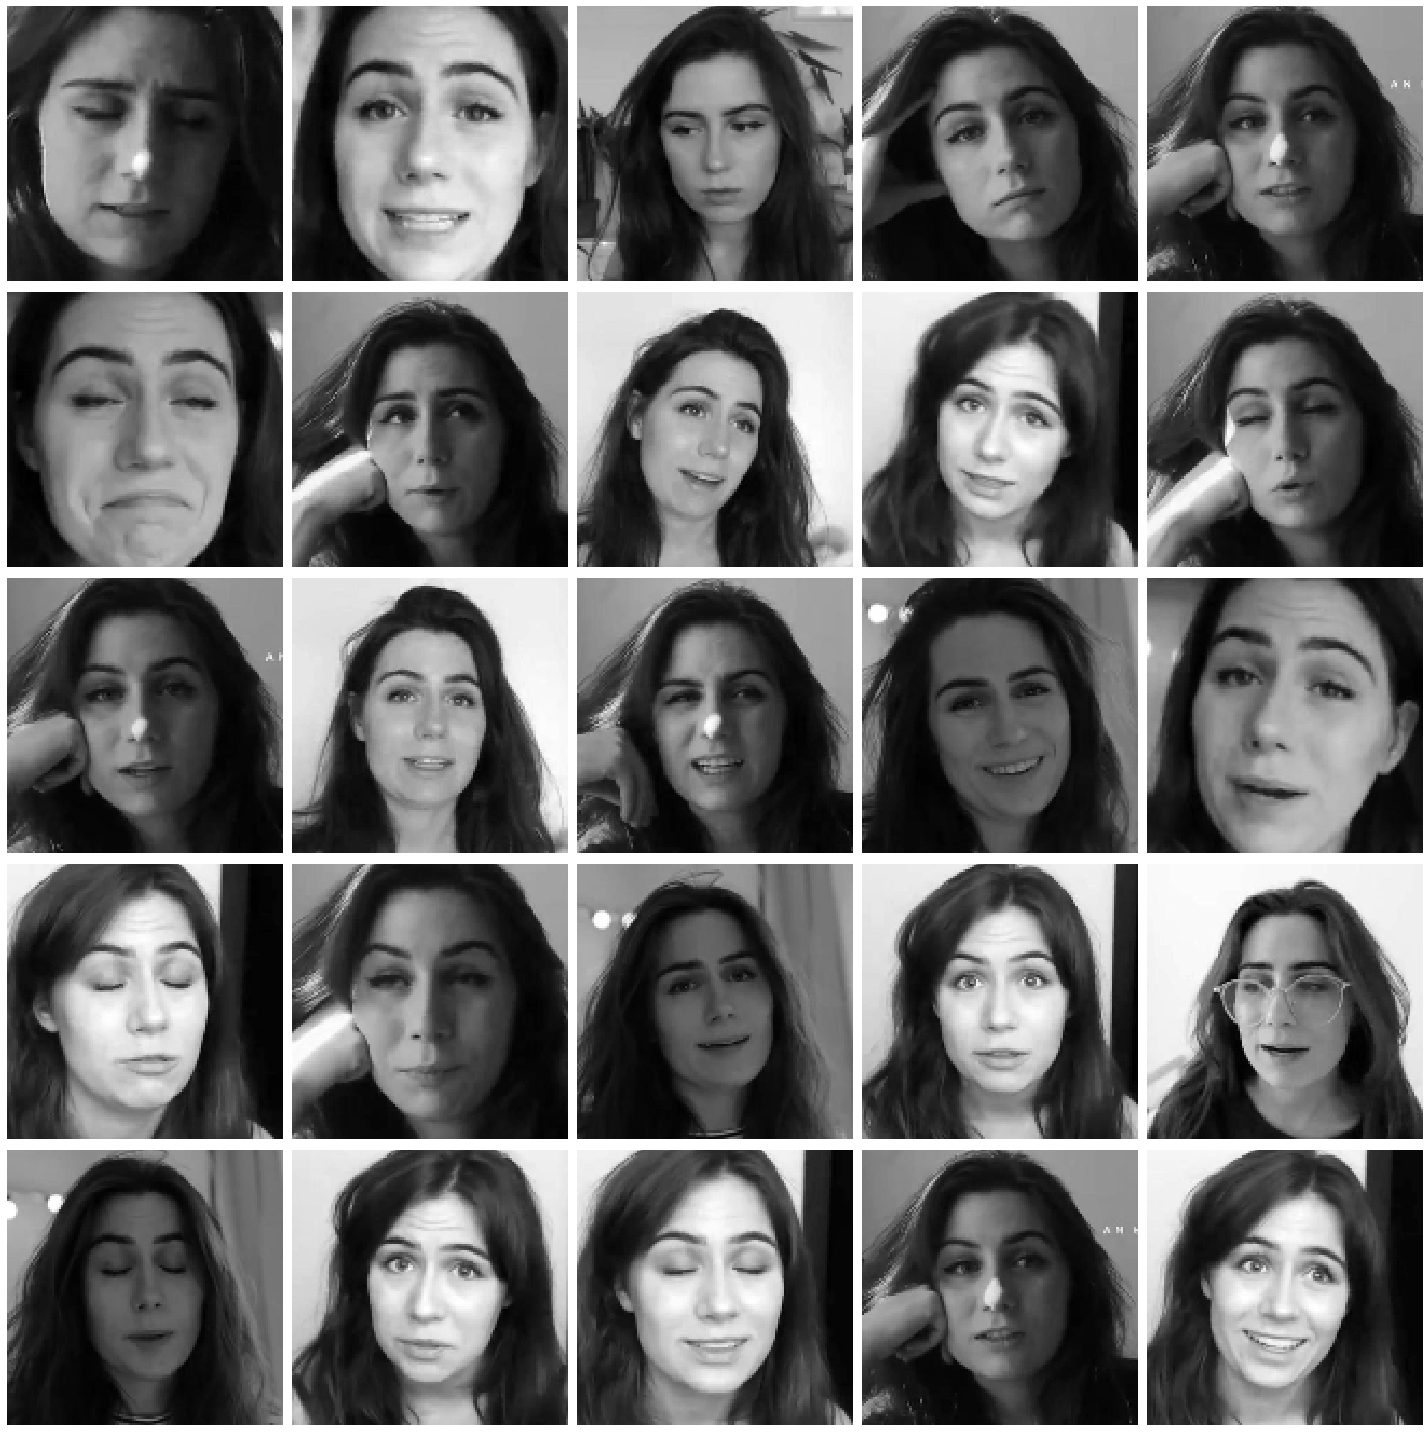

In [11]:
def plot_images(images_arr):
    fig, axes = plt.subplots(5, 5, figsize = (20, 20))
    axes = axes.flatten()
    
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

plot_images([image_data_generator[i][0][0] for i in range(25)])

## Training

In [12]:
fit_params = {
    'epochs': 10,
    'steps_per_epoch': 5186 // 2,
    'verbose': 1
}

#image_data_generator
history = model.fit(image_data_generator, **fit_params)

  ...
    to  
  ['...']
Train for 2593 steps
Epoch 1/10
2593/2593 [==============================] - 254s 98ms/step - loss: 0.0637
Epoch 2/10
2593/2593 [==============================] - 255s 98ms/step - loss: 0.0436
Epoch 3/10
2593/2593 [==============================] - 284s 109ms/step - loss: 0.0354
Epoch 4/10
2593/2593 [==============================] - 256s 99ms/step - loss: 0.0321
Epoch 5/10
2593/2593 [==============================] - 286s 110ms/step - loss: 0.0305
Epoch 6/10
2593/2593 [==============================] - 358s 138ms/step - loss: 0.0294
Epoch 7/10
2593/2593 [==============================] - 257s 99ms/step - loss: 0.0285
Epoch 8/10
2593/2593 [==============================] - 358s 138ms/step - loss: 0.0277
Epoch 9/10
2593/2593 [==============================] - 322s 124ms/step - loss: 0.0271
Epoch 10/10
2593/2593 [==============================] - 257s 99ms/step - loss: 0.0267


## Results

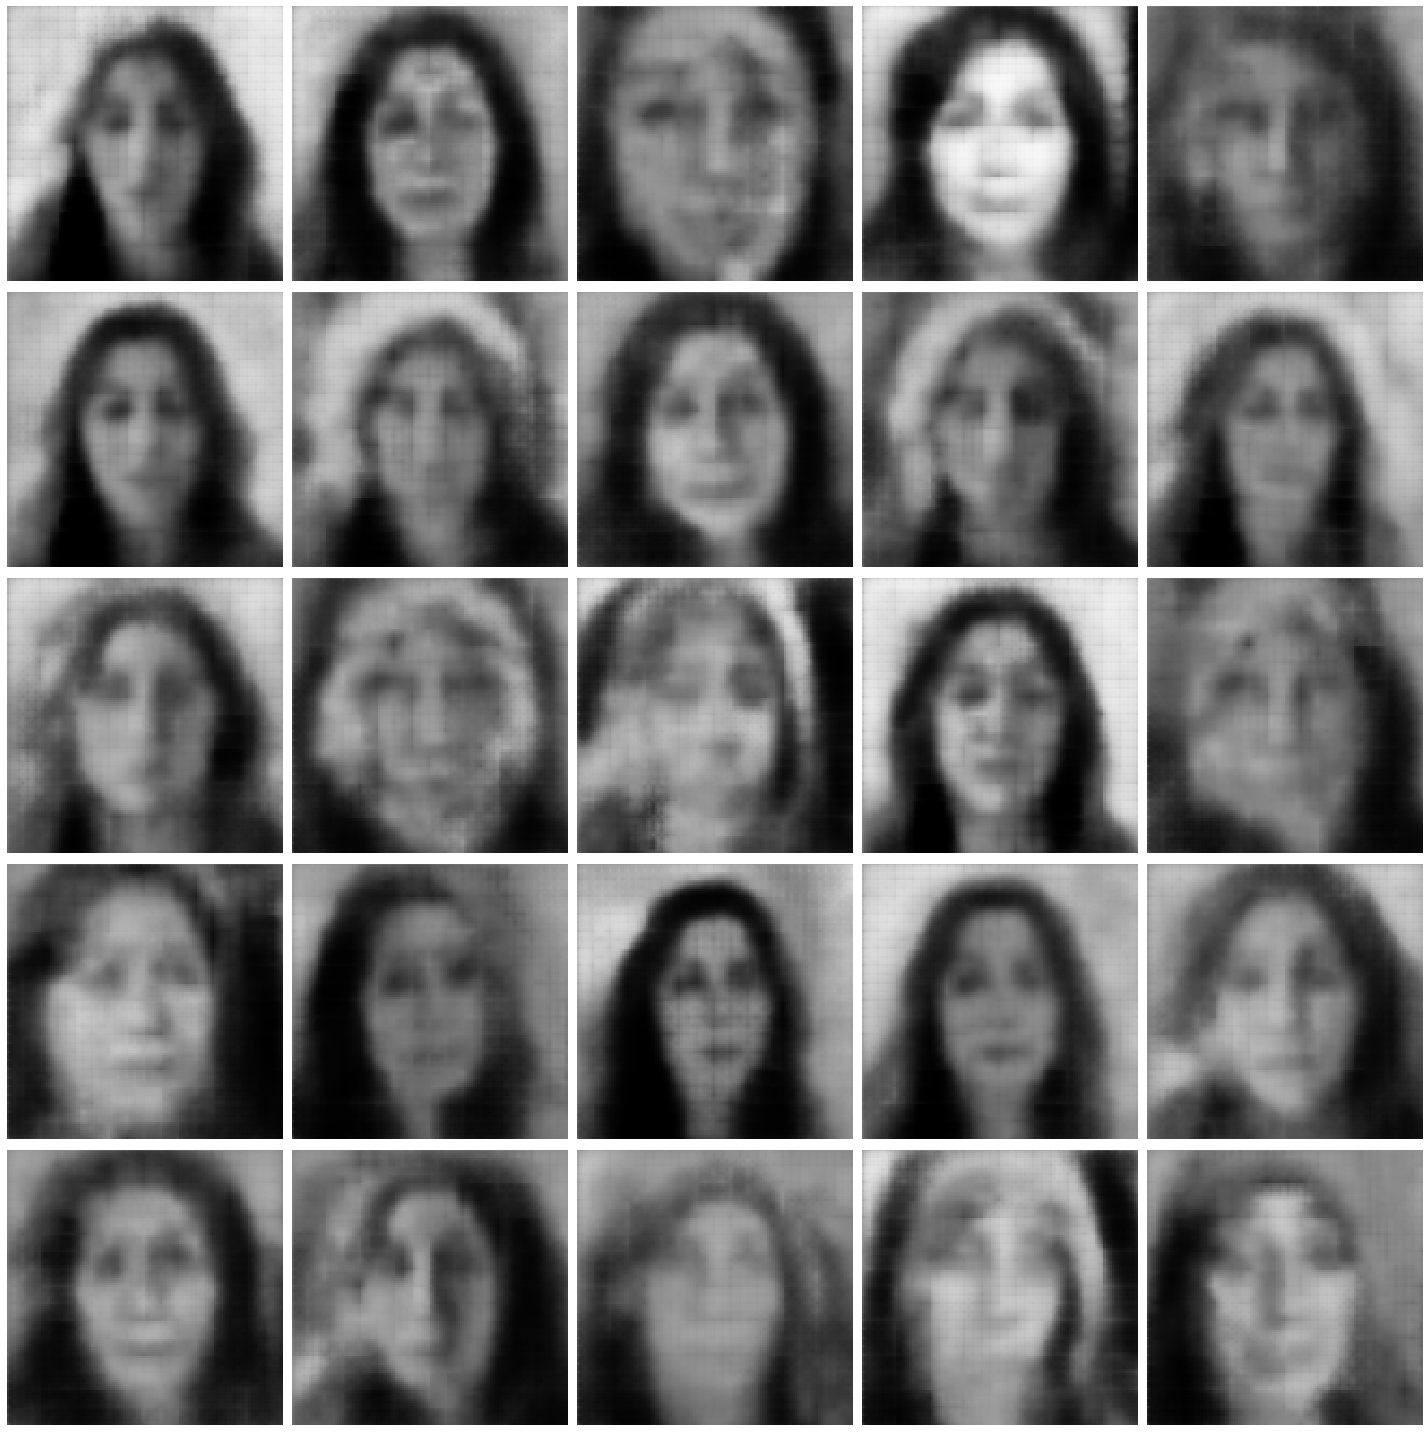

In [13]:
z_input = np.random.normal(size = [25, 200])
generated_image = decoder.predict(z_input)

fig, axes = plt.subplots(5, 5, figsize = (20, 20))
i = 0
for row in range(0, 5):
    for col in range(0, 5):
        current_image = generated_image[i]
        axes[row, col].axis('off')
        axes[row, col].imshow(current_image)
        i += 1

plt.tight_layout()
plt.show()
